## Prediction from trained model

In [1]:
spark

## Load the test dataframe

In [30]:
from __future__ import print_function

testDF = spark.read.format('parquet') \
        .load('/project/ML/data/test20k.parquet') \
        .select(['HLF_input', 'encoded_label']) \
        .withColumnRenamed('HLF_input', 'features')
        
test_events = testDF.count()
print('There are', test_events, 'test events')

There are 20000 test events


In [31]:
testDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- encoded_label: vector (nullable = true)



## Load the model

In [4]:
from bigdl.nn.layer import Model
from bigdl.util.common import init_engine
import numpy as np 

init_engine()

In [5]:
path = '/afs/cern.ch/work/m/migliori/public/BDLtest/pythonScripts/models/'
model = Model.loadModel(modelPath=path+'hlfHadalytic_hlf_10exe_6cores.bigdl',
                        weightPath=path+'hlfHadalytic_hlf_10exe_6cores.bin')

In [32]:
from bigdl.dlframes.dl_classifier import DLModel

predictior = DLModel(model=model, featureSize=[14])

creating: createDLModel


## Prediction

In [33]:
predDF = predictior.transform(testDF)

In [34]:
predDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- encoded_label: vector (nullable = true)
 |-- prediction: array (nullable = false)
 |    |-- element: double (containsNull = false)



In [35]:
predDF.show(5)

+--------------------+-------------+--------------------+
|            features|encoded_label|          prediction|
+--------------------+-------------+--------------------+
|[0.06865329588884...|(3,[1],[1.0])|[2.81666027149185...|
|[0.01563167840852...|(3,[0],[1.0])|[0.99877804517745...|
|[0.00626596377193...|(3,[2],[1.0])|[0.18347467482089...|
|[0.0,0.0375606796...|(3,[0],[1.0])|[0.18502448499202...|
|[0.00697752897271...|(3,[2],[1.0])|[0.13649576902389...|
+--------------------+-------------+--------------------+
only showing top 5 rows



## Compute auc

In [36]:
%%time
y_true = np.asarray(predDF.rdd.map(lambda row: \
                                   row.encoded_label).collect())
y_pred = np.asarray(predDF.rdd.map(lambda row: \
                                   row.prediction).collect())

CPU times: user 1.06 s, sys: 12.8 ms, total: 1.08 s
Wall time: 3.58 s


In [37]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

<IPython.core.display.Javascript object>


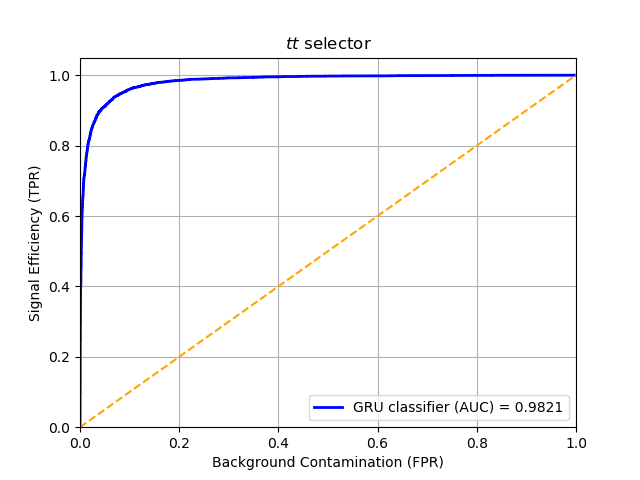

In [40]:
import matplotlib.pyplot as plt 
%matplotlib notebook

plt.figure()
plt.plot(fpr[0], tpr[0], color='blue',
         lw=2, label='GRU classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.grid()
plt.show()